In [1]:
# Import that good good
import sys
import os
sys.path.append('/Users/kolbt/Desktop/ipython/diam_files')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from IPython.display import display
from collections import OrderedDict
pd.options.display.max_rows = 2
import matplotlib.colors as mc
import colorsys

In [2]:
# Define what functions you'll need here
def getFromTxt(fname, first, last):
    "Takes a string, text before and after desired text, outs text between"
    start = fname.index( first ) + len( first )
    end = fname.index( last, start )
    myTxt = fname[start:end]
    return float(myTxt)
# Above function kindly provided by user "cji" on stackoverflow
# https://stackoverflow.com/questions/3368969/find-string-between-two-substrings

# Make sure data is sorted appropriately
def sortArray(array, sort_var):
    "Takes an array and the column name to sort, sorts array "
    for i in range(0, len(array)):
        for k in range(0, len(array[i])):
            for j in range(0, len(array[i])):
                # Out of order, swap them
                if array[i].loc[j, sort_var] < array[i].loc[k, sort_var] and k < j:
                    tmp = array[i].iloc[j].copy()
                    array[i].iloc[j] = array[i].iloc[k]
                    array[i].iloc[k] = tmp
                    
def plotter(start, stop, ylab):
    "Plotting function so that I don't have to show this a zillion times"
    ind = 0
    for j in range(start, stop):
        for i in range(0, len(SS[headers[j]])):
            # Mixture
            if params['xA'][i] % 100 != 0:
                plt.scatter(params['peA'][i], SS[headers[j]][i], c=col[ind], label=headers[j])
            # Monodisperse, always same color
            else:
                # If it's zero ignore it
                if SS[headers[j]][i] != 0:
                    plt.scatter(params['peA'][i], SS[headers[j]][i], c=col[-1], label='Mono')
        ind += 1
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.xlabel('Activity (Pe)')
    plt.ylabel(ylab)
    plt.show()
    
def katieRoseIsCute(r):
    "Take diameter, output LJ-force"
    eps = 20.0
    sigma = 1.0
    F_LJ = 24.0 * eps * ((2 * (sigma**12) * (r**-13)) - ((sigma**6) * (r**-7)))
    return F_LJ

def forceToEps(force):
    "Take LJ-force and output epsilon to give diameter of 1"
    epsilon = force / 24.0
    return epsilon

# https://mycurvefit.com/

def powerLaw(a, x, b):
    return a*(x**b)

def exponential(a, b, c, x):
    "Exponential: a - (b/c) * (1 - (e**-cx))"
    return a - ((b/c)*(1-(math.exp(-c*x))))

def plateau(a, x, b):
    "Plateau: a * x / (b + x)"
    return (a * x) / (b + x)

def logarithmic(a, x, b):
    "Logarithmic: a * ln(x) + b"
    if x != 0:
        return (a * math.log(x)) + b
    else:
        return 0
    
# https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
def colorShade(color, amount=0.5):
    "Gives multiple shades of a base color"
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
# Get the data files
txtFiles = os.listdir('diam_files')
all_sims = []

In [4]:
# Using the absolute path means I can go to whatever directory I want
os.chdir('/Users/kolbt/Desktop/ipython/diam_files')
for i in range(0, len(txtFiles)):
    df = pd.read_csv(txtFiles[i], sep='\s+', header=0)
    all_sims.append(df)
    
# Return to root directory
os.chdir('/Users/kolbt/Desktop/ipython')

In [5]:
# Make sure all data is in correct timestep order
sortArray(all_sims, 'Timestep')
display(all_sims[9])

,Timestep,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lg_clust,MCS,sigALL,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density
0,0.0,100000,0,100000,0,0,0,5,0,1.0313,1.0313,0.0,0.0,0.62,4.2,0.0,1.2,0.0,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,749998800.0,4963,0,4963,95037,0,95037,95037,95037,0.9525,0.9525,0.0,0.0,0.57,67719.3,67719.3,1.4,1.4,0.08


In [6]:
# Make an additional frame that gives total number of particles, and simulation parameters
paramList = []
for i in range(0, len(txtFiles)):
    partAll = all_sims[i]['Gas_tot'][0]
    partA = all_sims[i]['Gas_A'][0]
    partB = all_sims[i]['Gas_B'][0]
    pa = getFromTxt(txtFiles[i], "pa", "_pb")
    pb = getFromTxt(txtFiles[i], "pb", "_xa")
    xa = getFromTxt(txtFiles[i], "xa", ".txt")
    try:
        prat = float(pa)/float(pb)
    except:
        prat = 0.0
    paramList.append((partAll, partA, partB, pa, pb, xa, prat))

params = pd.DataFrame(paramList, columns=['partAll', 'partA', 'partB', 'peA', 'peB', 'xA', 'peR'])
display(params)

,partAll,partA,partB,peA,peB,xA,peR
0,100000.0,50000.0,50000.0,0.0,500.0,50.0,0.0
...,...,...,...,...,...,...,...
21,100000.0,100000.0,0.0,60.0,0.0,100.0,0.0


In [7]:
# Make list of steady state column headers
headers = list(all_sims[0])
headers.remove('Timestep')
SS = pd.DataFrame(columns=headers)
for i in range(0, len(txtFiles)):
    SS.loc[i] = [0] * len(headers)

# Make dataframe of steady-state data
for i in range(0, len(txtFiles)):
    # Loop through each column (aside from tstep column)
    for j in range(1, len(headers) + 1):
        # Compute mean of last 100 entries in jth column of ith file
        avg = np.mean(all_sims[i].iloc[-100:-1,j])
        SS[headers[j-1]][i] = avg
        
# Normalize by number of particles
# SS['Gas_A'][:] /= params['partA'][:]
# SS['Gas_B'][:] /= params['partB'][:]
# SS['Gas_tot'][:] /= params['partAll'][:]
# SS['Dense_A'][:] /= params['partA'][:]
# SS['Dense_B'][:] /= params['partB'][:]
# SS['Dense_tot'][:] /= params['partAll'][:]
# SS['Lg_clust'][:] /= params['partAll'][:]
# SS['MCS'][:] /= params['partAll'][:]
display(SS)

,Gas_A,Gas_B,Gas_tot,Dense_A,Dense_B,Dense_tot,Lg_clust,MCS,sigALL,sigAA,sigAB,sigBB,phiEff,lg_clustA,tot_clustA,LC_density,DP_density,GP_density
0,19471,4793.1,24264.1,30529,45206.9,75735.9,75358,72345.6,0.995979,0.977317,0.994729,0.997486,0.597778,57936.9,58229.8,1.30071,1.30071,0.333131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,29480.5,0,29480.5,70519.5,0,70519.5,69191.9,68059.7,0.992815,0.992815,0,0,0.596768,53567.4,54593.7,1.29222,1.29222,0.386162


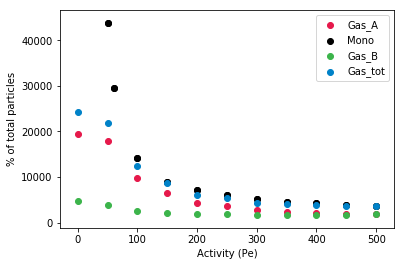

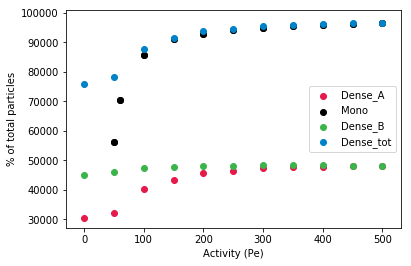

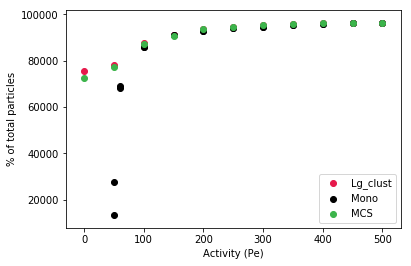

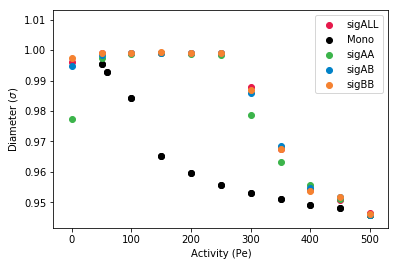

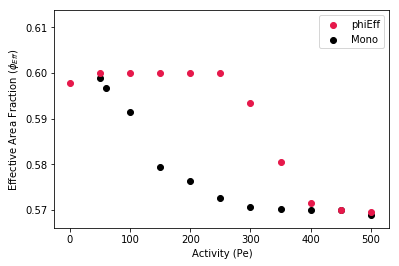

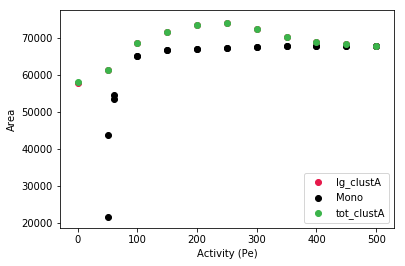

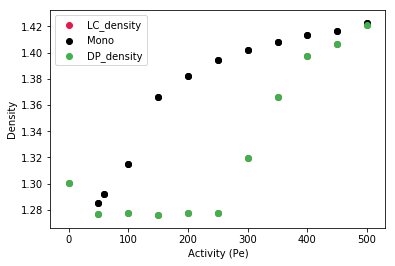

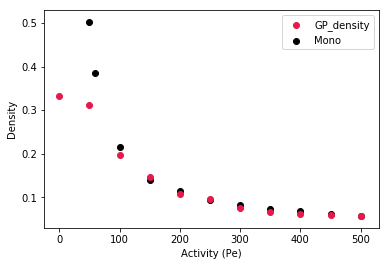

In [8]:
# Plot the data
# col = ['k', 'r', 'g', 'b']
col = ['#e6194b', '#3cb44b', '#0082c8', '#f58231', '#ffe119','#911eb4', '#46f0f0',
       '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff', '#aa6e28', '#fffac8',
       '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000080', '#808080', '#ffffff',
       '#000000']
plotter(0, 3, '% of total particles')
plotter(3, 6, '% of total particles')
plotter(6, 8, '% of total particles')
plotter(8, 12, r'Diameter $(\sigma)$')
plotter(12, 13, r'Effective Area Fraction $(\phi_{Eff})$')
plotter(13, 15, 'Area')
plotter(15, 17, 'Density')
plotter(17, 18, 'Density')

# # This is the way I was plotting it
# for j in range(0, 3):
#     plt.scatter(params['peA'], SS[headers[j]], label=headers[j])
#     plt.legend()
# plt.show()

In [9]:
# Take in the steady-state diameter data... output the LJ force w/ HS epsilon
diam_to_force = []
eps_one = []
for i in range(0, len(SS['sigALL'])):
    diam_to_force.append(katieRoseIsCute(SS['sigALL'][i]))
    eps_one.append(forceToEps(diam_to_force[i]))

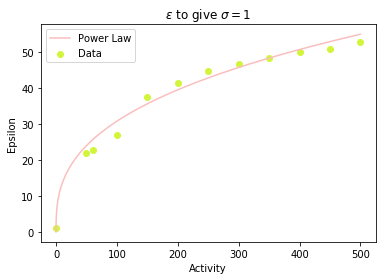

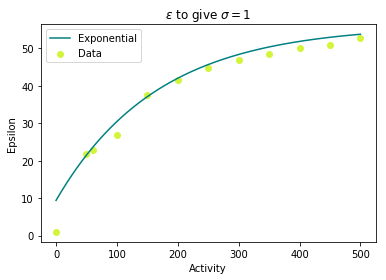

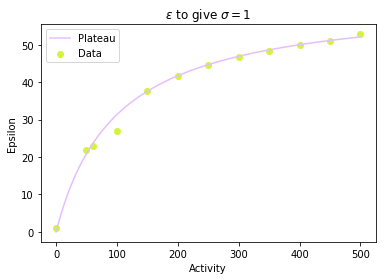

In [10]:
# https://onlinelibrary.wiley.com/doi/pdf/10.1002/9780470126714.app4
# Good ideas for plotting are:
#  Exponential: a - (b/c) * (1 - (e**-cx))
#  Power: a * x ** b
#  Plateau: a * x / (b + x)
#  Log: a * ln(x) + b

# Let's fix the data being plotted (just monodisperse)
mono = [0]
corDat = [1]
for i in range(0, len(params['peA'])):
    if params['xA'][i] % 100 == 0:
        mono.append(params['peA'][i])
        corDat.append(eps_one[i])

powla = []
expo = []
plato = []
loga = []
refRange = np.arange(0, 500, 0.001)
for i in range(0, len(refRange)):
    powla.append(powerLaw(5.87, refRange[i], 0.36))
    expo.append(exponential(9.4, -0.28, 0.006, refRange[i]))
    plato.append(plateau(62.4, refRange[i], 99.1))
    loga.append(logarithmic(1.0, refRange[i], 1.0))

plt.scatter(mono, corDat, c=col[8], label='Data')
plt.plot(refRange, powla, c=col[9], label='Power Law')
plt.xlabel('Activity')
plt.ylabel('Epsilon')
plt.legend()
plt.title(r'$\epsilon$ to give $\sigma=1$')
plt.show()

plt.scatter(mono, corDat, c=col[8], label='Data')
plt.plot(refRange, expo, c=col[10], label='Exponential')
plt.xlabel('Activity')
plt.ylabel('Epsilon')
plt.legend()
plt.title(r'$\epsilon$ to give $\sigma=1$')
plt.show()

plt.scatter(mono, corDat, c=col[8], label='Data')
plt.plot(refRange, plato, c=col[11], label='Plateau')
plt.xlabel('Activity')
plt.ylabel('Epsilon')
plt.legend()
plt.title(r'$\epsilon$ to give $\sigma=1$')
plt.show()

# plt.scatter(mono, corDat, c=col[8], label='Data')
# plt.plot(refRange, loga, c=col[12], label='Logarithmic')
# plt.xlabel('Activity')
# plt.ylabel('Epsilon')
# plt.legend()
# plt.title(r'$\epsilon$ to give $\sigma=1$')
# plt.show()

In [11]:
print('Monodisperse Data:')
for i in range(0, len(eps_one)):
    # monodisperse
    if params['xA'][i] % 100 == 0:
        print('Activity: {}, Epsilon: {}').format(params['peA'][i], eps_one[i])
# print('Monodisperse Data:')
# for i in range(0, len(eps_one)):
#     # monodisperse
#     if params['xA'][i] % 100 == 0:
#         print('{} \t {}').format(params['peA'][i], eps_one[i])

Monodisperse Data:
Activity: 100.0, Epsilon: 26.8534827824
Activity: 150.0, Epsilon: 37.6397874077
Activity: 200.0, Epsilon: 41.5519027436
Activity: 250.0, Epsilon: 44.6809112352
Activity: 300.0, Epsilon: 46.7550043594
Activity: 350.0, Epsilon: 48.4091749773
Activity: 400.0, Epsilon: 50.0417962436
Activity: 450.0, Epsilon: 50.9646829236
Activity: 500.0, Epsilon: 52.7877441901
Activity: 50.0, Epsilon: 21.8620004183
Activity: 60.0, Epsilon: 22.8955530146


Text(0,0.5,'% of Total B')

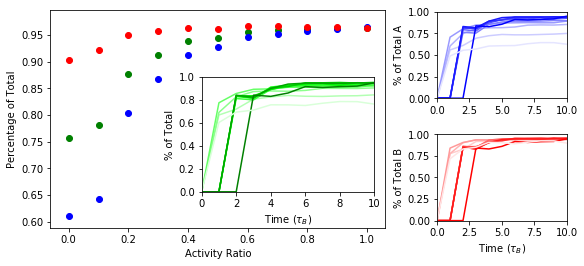

In [12]:
# Plot the composition data? Inset the plot composition over time
# A will be one color, dark = high Pe_ratio, light = low Pe_r
# Same goes for B and all

mixPar = []
mixA = []
mixB = []
mixT = []
mixInds = []
for i in range(0, len(params['peA'])):
    # Mixtures only
    if params['xA'][i] % 100 != 0:
        mixInds.append(i)
        mixPar.append(params['peR'][i])
        mixA.append(SS['Dense_A'][i] / params['partA'][i])
        mixB.append(SS['Dense_B'][i] / params['partB'][i])
        mixT.append(SS['Dense_tot'][i] / params['partAll'][i])
        
plt.scatter(mixPar, mixT, label='All', c='g')
plt.scatter(mixPar, mixA, label='A', c='b')
plt.scatter(mixPar, mixB, label='B', c='r')
plt.xlabel('Activity Ratio')
plt.ylabel('Percentage of Total')

mixedSims = len(mixInds)
timeB = [[] for x in xrange(mixedSims)]
simDenseA = [[] for x in xrange(mixedSims)]
simDenseB = [[] for x in xrange(mixedSims)]
simDenseT = [[] for x in xrange(mixedSims)]

count = -1
# Let's get data for the inset
for i in range(0, len(txtFiles)):
    if params['xA'][i] % 100 != 0:
        count += 1
        # Get the tau_B time
        timeB[count].append(np.arange(0, len(all_sims[i]['Timestep']), 1))
        for j in range(0, len(all_sims[i]['Timestep'])):
            # Group all Dense_A data
            simDenseT[count].append(all_sims[i]['Dense_tot'][j])
            simDenseA[count].append(all_sims[i]['Dense_A'][j])
            simDenseB[count].append(all_sims[i]['Dense_B'][j])
        # Divide column by number of A particles
        simDenseT[count] /= params['partAll'][i]
        simDenseA[count] /= params['partA'][i]
        simDenseB[count] /= params['partB'][i]
    
# Plot the data All
a = plt.axes([0.475, .25, .4, .4], facecolor='w')
for i in range(0, mixedSims):
    plt.plot(timeB[i][0], simDenseT[i], c=colorShade('g', mixPar[i]))
plt.xlim(0, 10)
plt.ylim(0,1)
plt.xlabel(r'Time $(\tau_{B})$')
plt.ylabel(r'% of Total')    

# Plot the data A
a = plt.axes([1.02, .575, .3, .3], facecolor='w')
for i in range(0, mixedSims):
    plt.plot(timeB[i][0], simDenseA[i], c=colorShade('b', mixPar[i]))
plt.xlim(0, 10)
plt.ylim(0,1)
plt.ylabel(r'% of Total A')

# Plot the data B
a = plt.axes([1.02, .15, .3, .3], facecolor='w')
for i in range(0, mixedSims):
    plt.plot(timeB[i][0], simDenseB[i], c=colorShade('r', mixPar[i]))
plt.xlim(0, 10)
plt.ylim(0,1)
plt.xlabel(r'Time $(\tau_{B})$')
plt.ylabel(r'% of Total B')